In [1]:
# I/O
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Dataset
import numpy as np
import netCDF4 as nc

# Plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Time
import time

# Video
from IPython.display import Video

In [2]:
def filename_constructor(time_index, case, var):
    return str(f"/data/cloud2023/vvmData{case}/archive{var}-{str(time_index).zfill(6)}.nc")

casenames = ["/rce_walker_15k_05m_p3",
             "/rce_walker_15k_1m_p3",
             "/rce_walker_1k_1m_p3",
             "/rce_walker_1k_2m_p3"]
varnames = ["/exp.C.LandSurface",
            "/exp.C.Surface",
            "/exp.L.Dynamic",
            "/exp.L.Radiation",
            "/exp.L.Thermodynamic"]
os.getcwd()

'/data/cloud2023/r12229008/HW5'

In [3]:
"""
To reach a better understanding about convection, sampled convection area and producce a composite image
Method:
For every single file, and every latitude (or y), choose a snapshot (x-z coordinate), and pick convection area
by rectangle that
center : extreme updraft & downdraft at 3km
length = 48 km
then calculate the mean of these snapshot
"""
# Initialize dataset
case_id = 3
dataset = nc.Dataset(filename_constructor(str(0).zfill(6), casenames[case_id], varnames[2]))
xc = dataset["xc"][:]
yc = dataset["yc"][:]
zc = dataset["zc"][:]

    # composite rectangle
z_index = 13
z_index_len = 30
x_index_len = 24
    # composite data
    # the first dim with 5 elements are: u, v, thv, qc, qi
temp = np.zeros((5,z_index_len, 2*x_index_len+1))
min_inf_3 = np.zeros_like(temp)
min_3_1 = np.zeros_like(temp)
min_1_0 = np.zeros_like(temp)
max_0_1 = np.zeros_like(temp)
max_1_3 = np.zeros_like(temp)
max_3_inf = np.zeros_like(temp)
    # composite number
num_ninf = 0
num_n3 = 0
num_n1 = 0
num_p1 = 0
num_p3 = 0
num_pinf = 0

# Step 1.
# Determine convection center by updraft/downdraft
for time in range(0,1200):
    # current timestep
    if (time%100==0):
        print(time)
    # current data
    dataset_Dyn = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[case_id], varnames[2]))
    dataset_Thm = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[case_id], varnames[-1]))
    # current vertical velocity
    w = dataset_Dyn["w"][-1,z_index,:,:]
    updraft_centre = np.argmax(w, axis = 1)
    downdraft_centre = np.argmin(w, axis = 1)
    # For simplicity, check centre is valid
    for y_index in range(len(updraft_centre)):
        center = updraft_centre[y_index]
        if (center <= (0+x_index_len) or center >= (512-x_index_len)):
            #print("OUT OF BOUNDS")
            pass
        else:
        # Step 2.
        # Calculate associated variable
            # center - length_index:center + length_index+1
            u = dataset_Dyn["u"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            w = dataset_Dyn["w"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            qc = dataset_Thm["qc"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            qi = dataset_Thm["qi"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            
            th = dataset_Thm["th"][-1,:z_index_len,y_index,:]
            qv = dataset_Thm["qv"][-1,:z_index_len,y_index,:]
            thv = th*(1 + 0.608*qv)
            thv -= np.mean(thv, axis = 1).reshape(-1,1)
            thv = thv[:,center-x_index_len:center+x_index_len+1]
            criteria = np.max(w)
            if criteria > 3:
                max_3_inf[0,:,:] += u
                max_3_inf[1,:,:] += w
                max_3_inf[2,:,:] += thv
                max_3_inf[3,:,:] += qc
                max_3_inf[4,:,:] += qi
                num_pinf += 1
                pass
            elif criteria > 1:
                max_1_3[0,:,:] += u
                max_1_3[1,:,:] += w
                max_1_3[2,:,:] += thv
                max_1_3[3,:,:] += qc
                max_1_3[4,:,:] += qi
                num_p3 += 1
                pass
            elif criteria > 0:
                max_0_1[0,:,:] += u
                max_0_1[1,:,:] += w
                max_0_1[2,:,:] += thv
                max_0_1[3,:,:] += qc
                max_0_1[4,:,:] += qi
                num_p1 += 1
                pass
            else:
                pass
    for y_index in range(len(downdraft_centre)):
        center = downdraft_centre[y_index]
        if (center <= (0+x_index_len) or center >= (512-x_index_len)):
            #print("OUT OF BOUNDS")
            pass
        else:
        # Step 2.
        # Calculate associated variable
            # center - length_index:center + length_index+1
            u = dataset_Dyn["u"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            w = dataset_Dyn["w"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            qc = dataset_Thm["qc"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            qi = dataset_Thm["qi"][-1,:z_index_len,y_index,center-x_index_len:center+x_index_len+1]
            
            th = dataset_Thm["th"][-1,:z_index_len,y_index,:]
            qv = dataset_Thm["qv"][-1,:z_index_len,y_index,:]
            thv = th*(1 + 0.608*qv)
            thv -= np.mean(thv, axis = 1).reshape(-1,1)
            thv = thv[:,center-x_index_len:center+x_index_len+1]
            criteria = np.min(w)
            if criteria < -3:
                min_inf_3[0,:,:] += u
                min_inf_3[1,:,:] += w
                min_inf_3[2,:,:] += thv
                min_inf_3[3,:,:] += qc
                min_inf_3[4,:,:] += qi
                num_ninf += 1
                pass
            elif criteria < -1:
                min_3_1[0,:,:] += u
                min_3_1[1,:,:] += w
                min_3_1[2,:,:] += thv
                min_3_1[3,:,:] += qc
                min_3_1[4,:,:] += qi
                num_n3 += 1
                pass
            elif criteria < 0:
                min_1_0[0,:,:] += u
                min_1_0[1,:,:] += w
                min_1_0[2,:,:] += thv
                min_1_0[3,:,:] += qc
                min_1_0[4,:,:] += qi
                num_n1 += 1
                pass
            else:
                pass
min_inf_3 /= num_ninf
min_3_1 /= num_n3
min_1_0 /= num_n1
max_0_1 /= num_p1
max_1_3 /= num_p3
max_3_inf /= num_pinf

0
100
200
300
400
500
600
700
800
900
1000
1100


In [4]:
x = np.linspace(-48,48,49)
z = zc[:z_index_len]/1e3
xx,zz = np.meshgrid(x,z)

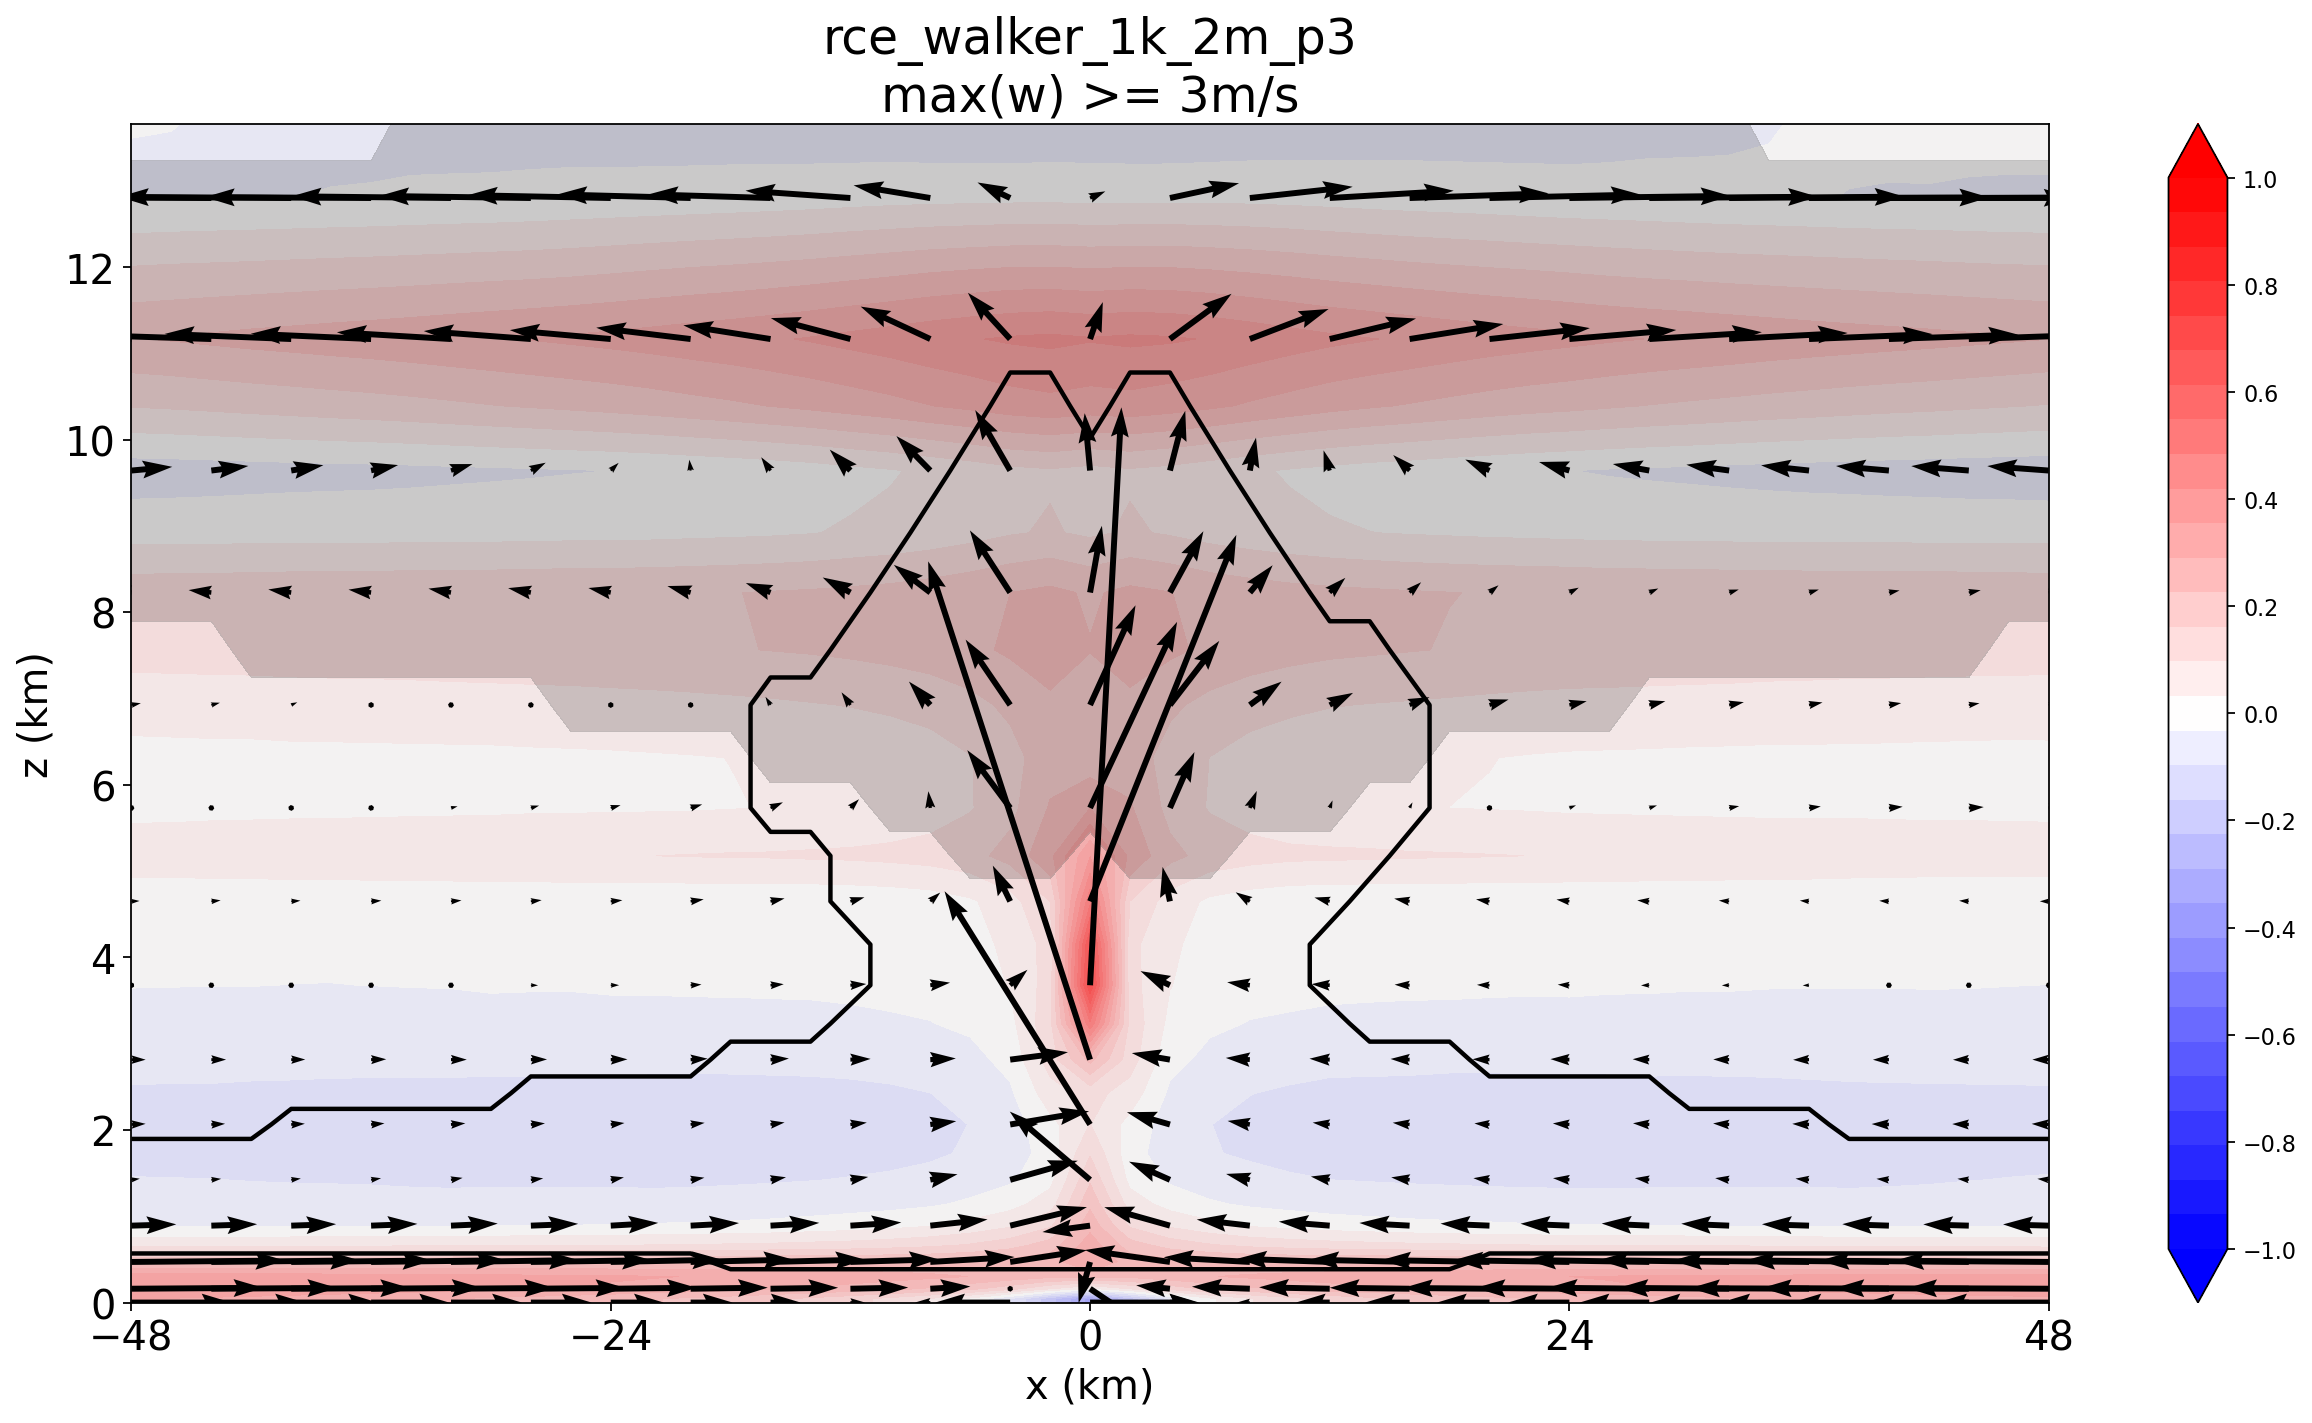

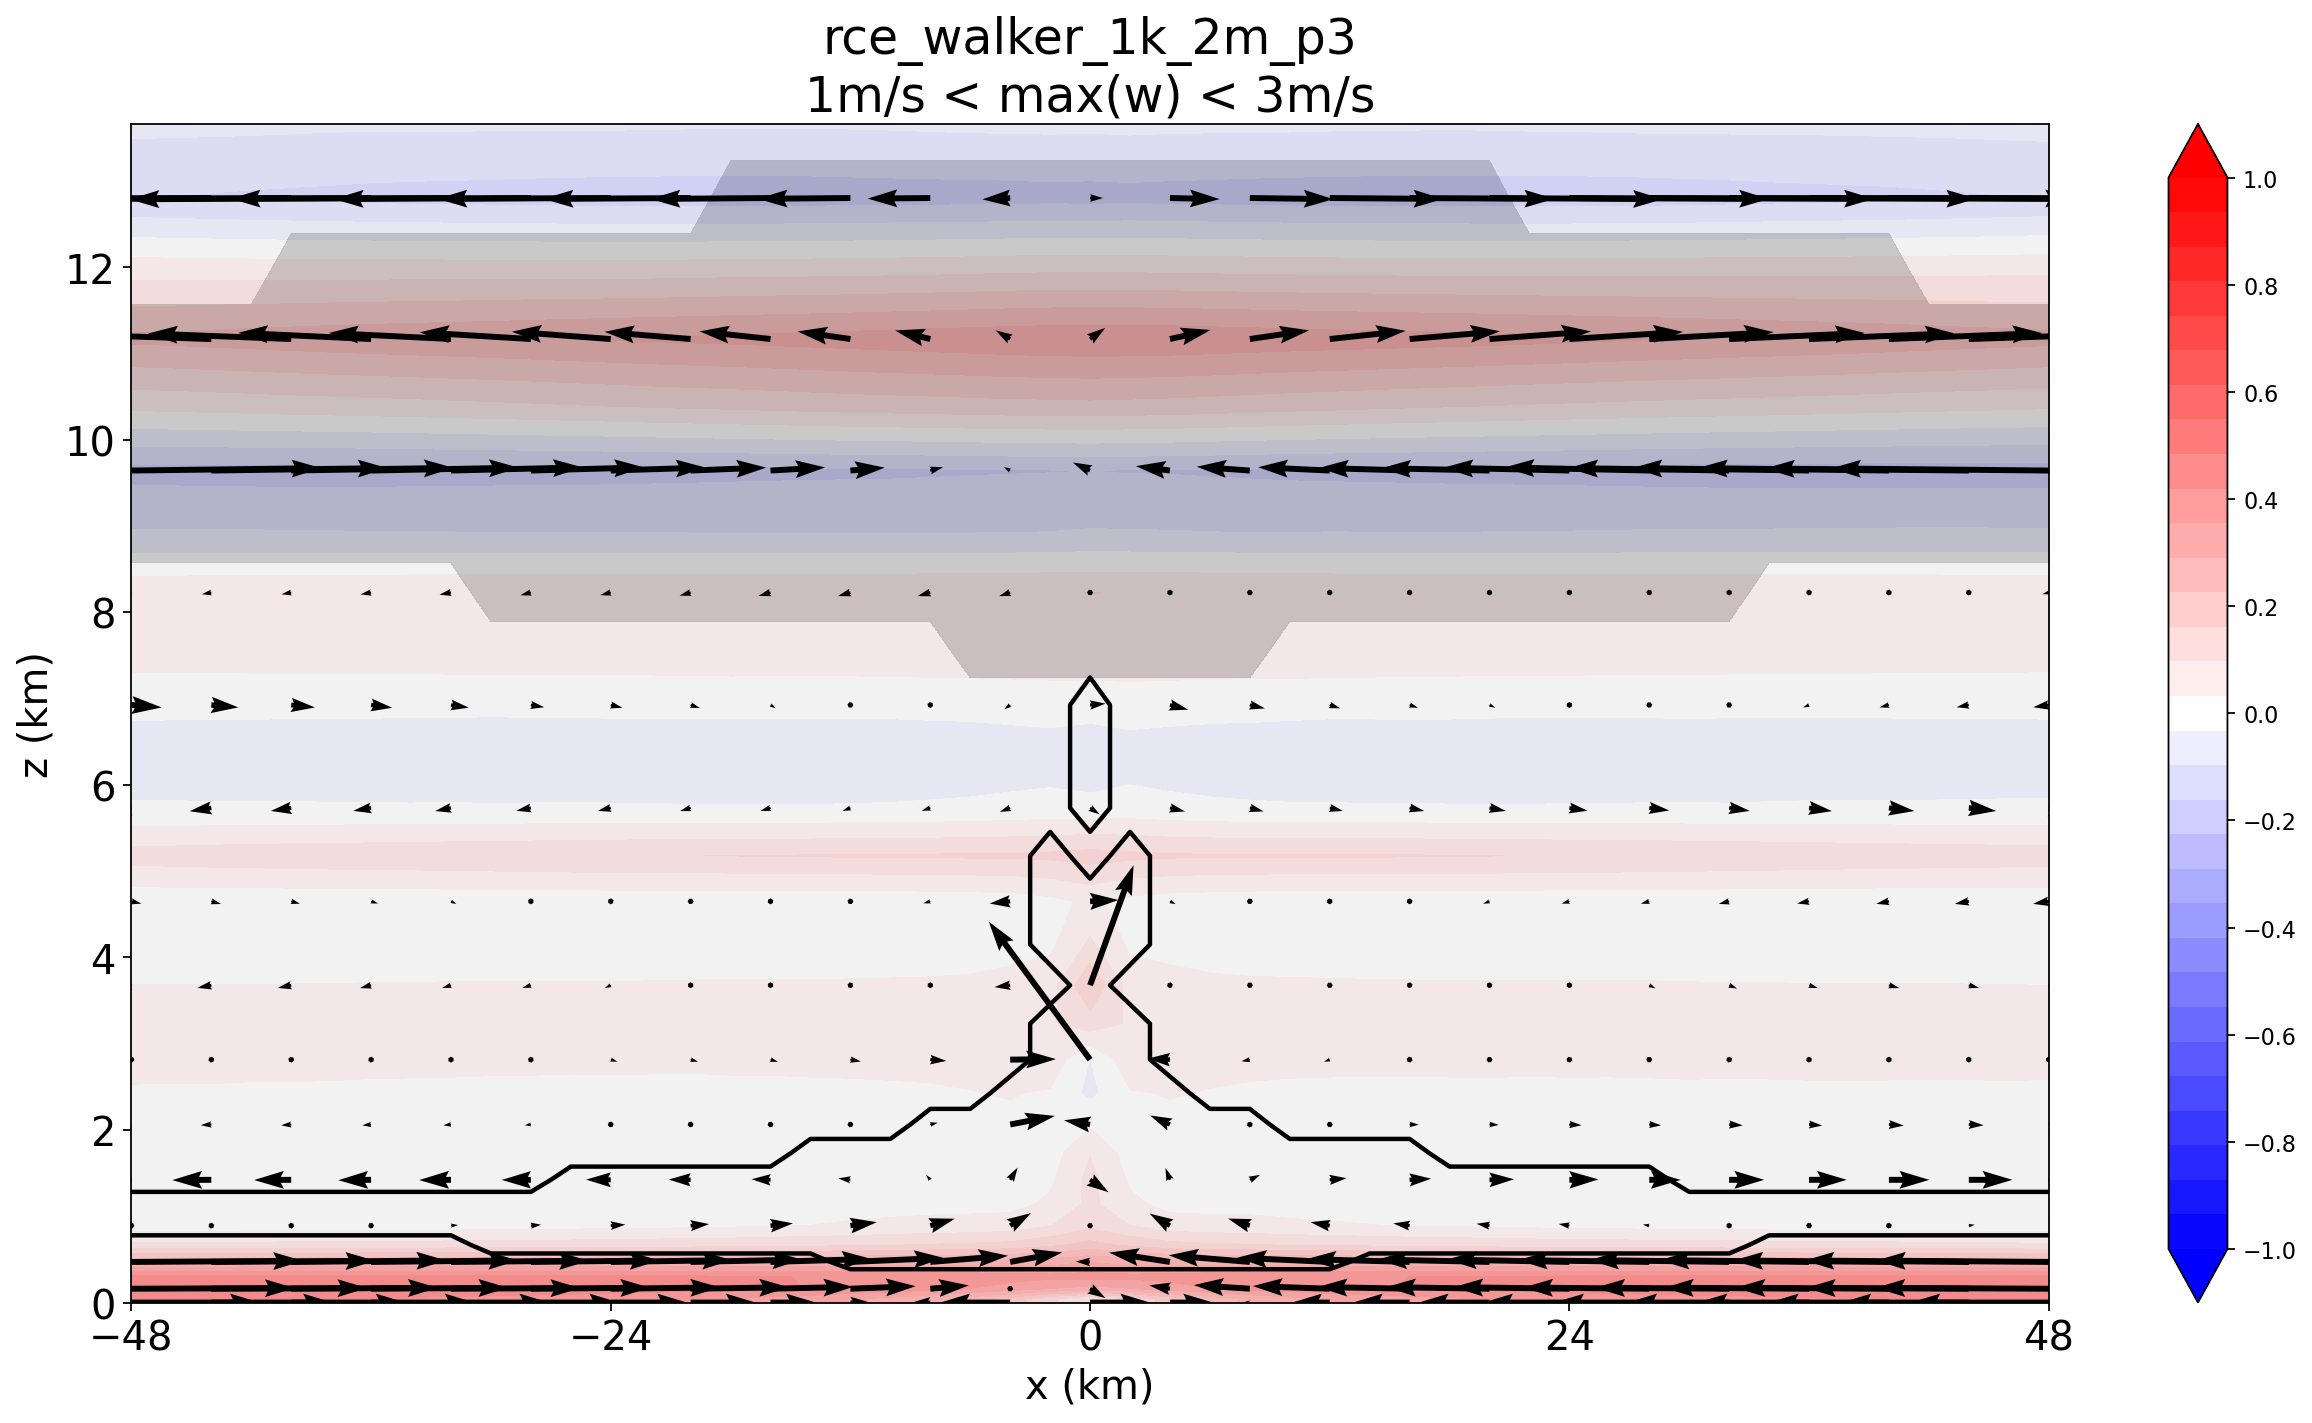

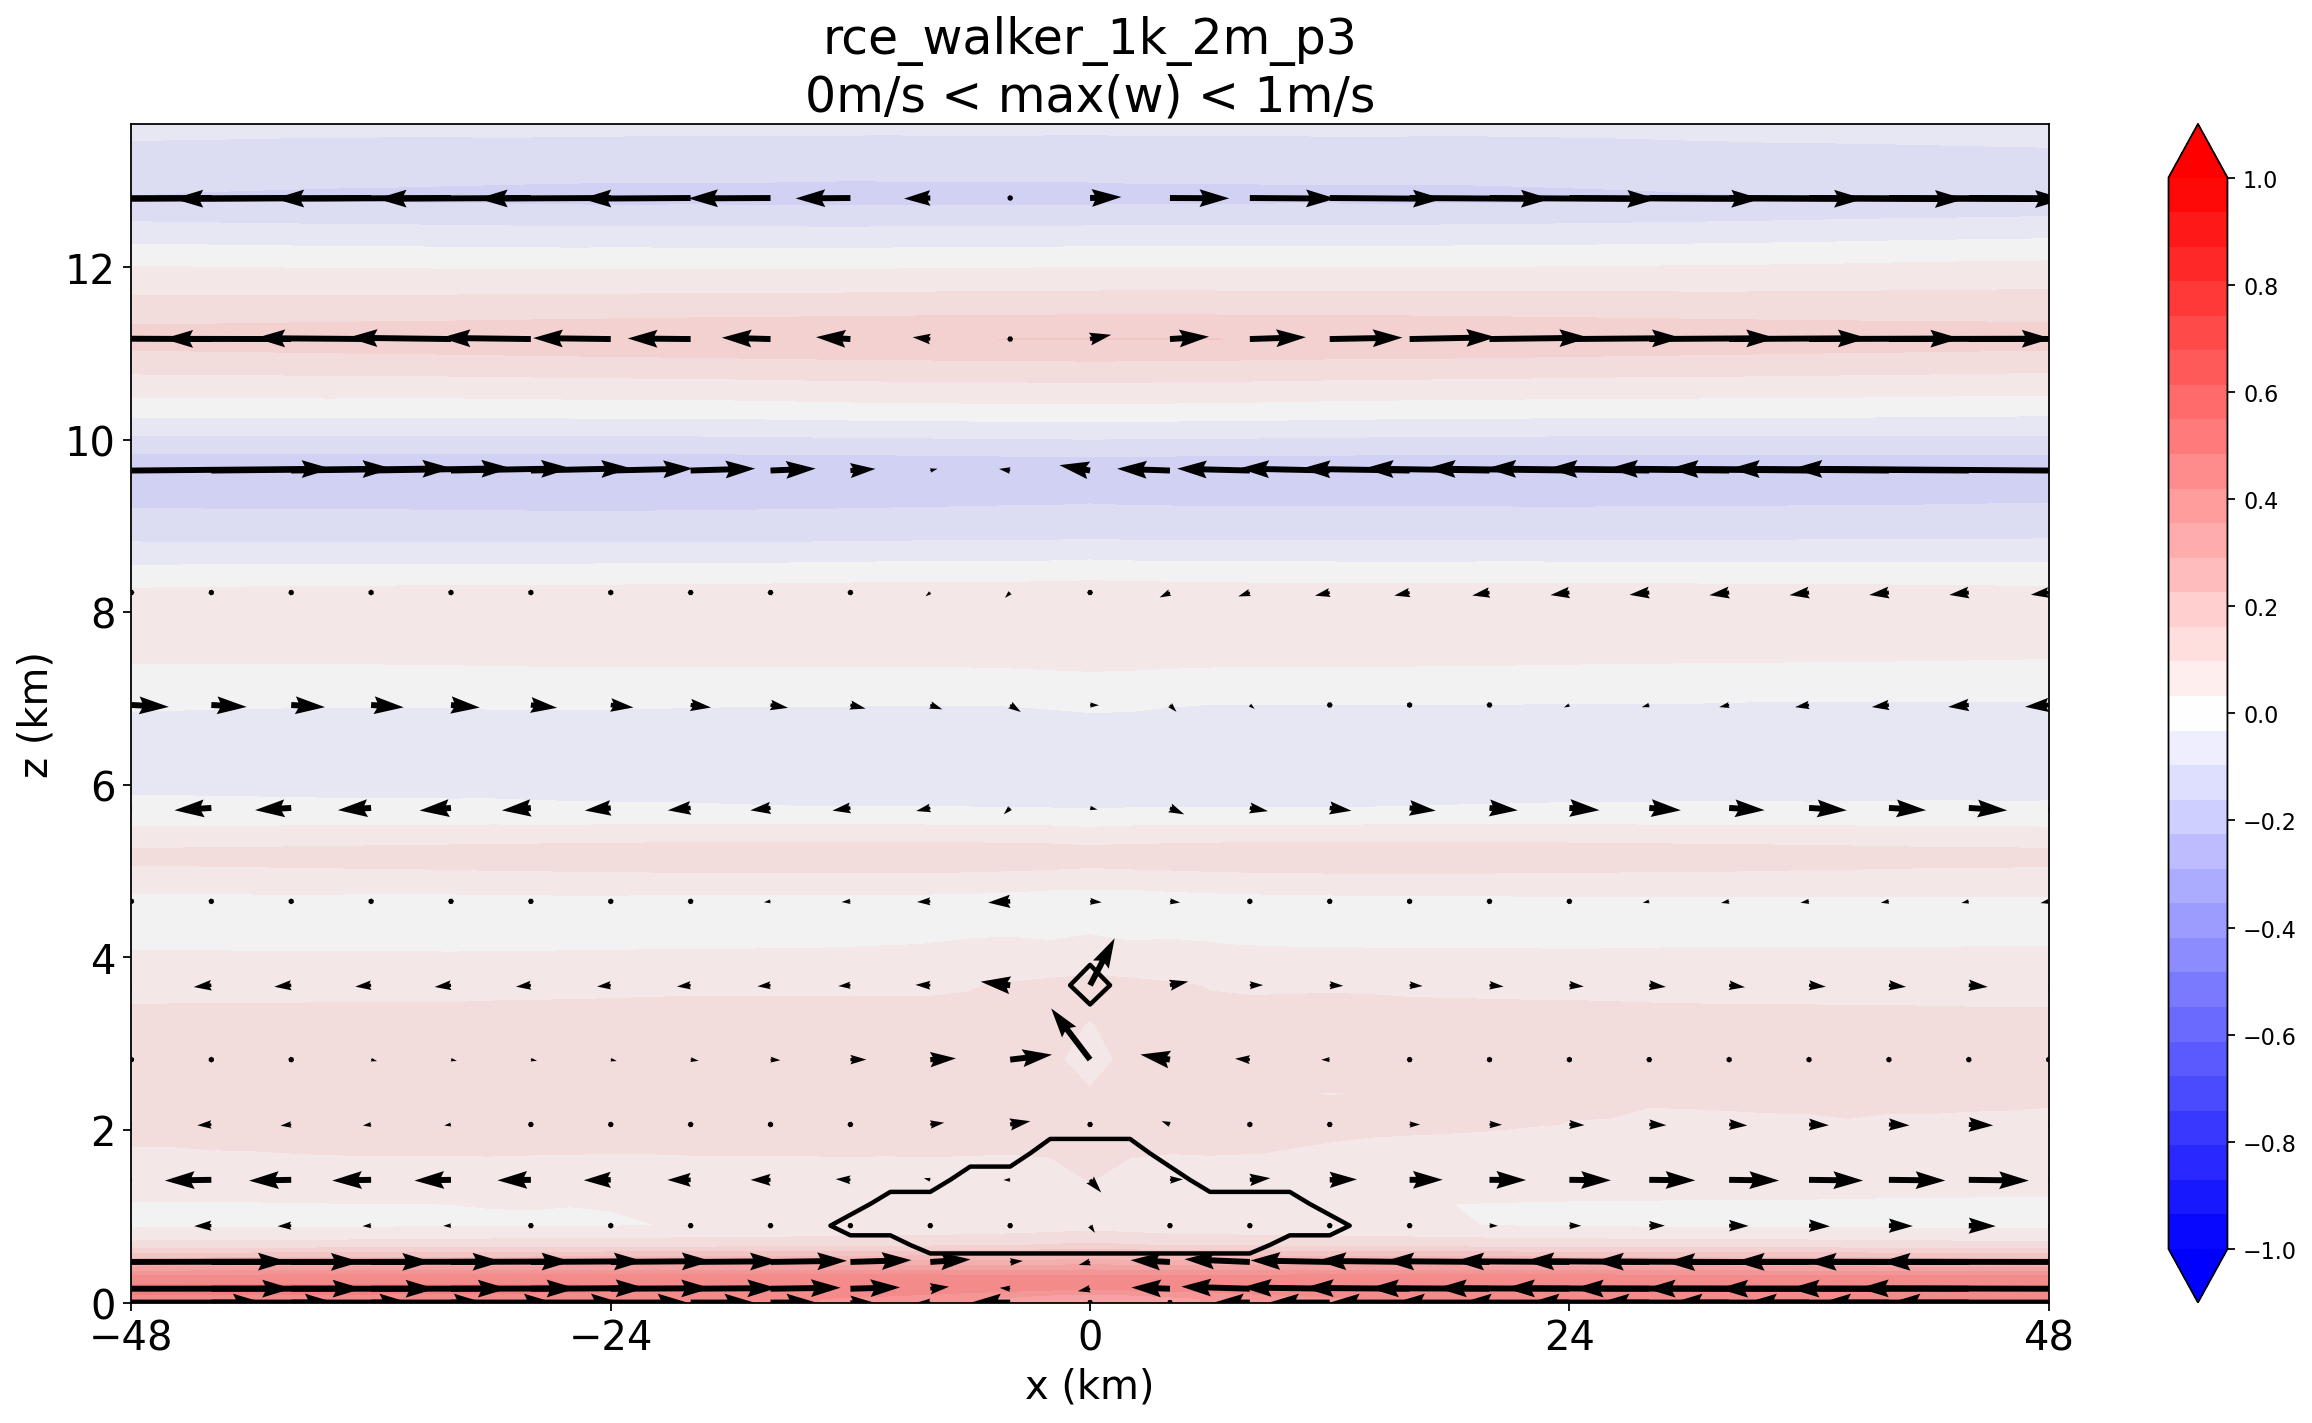

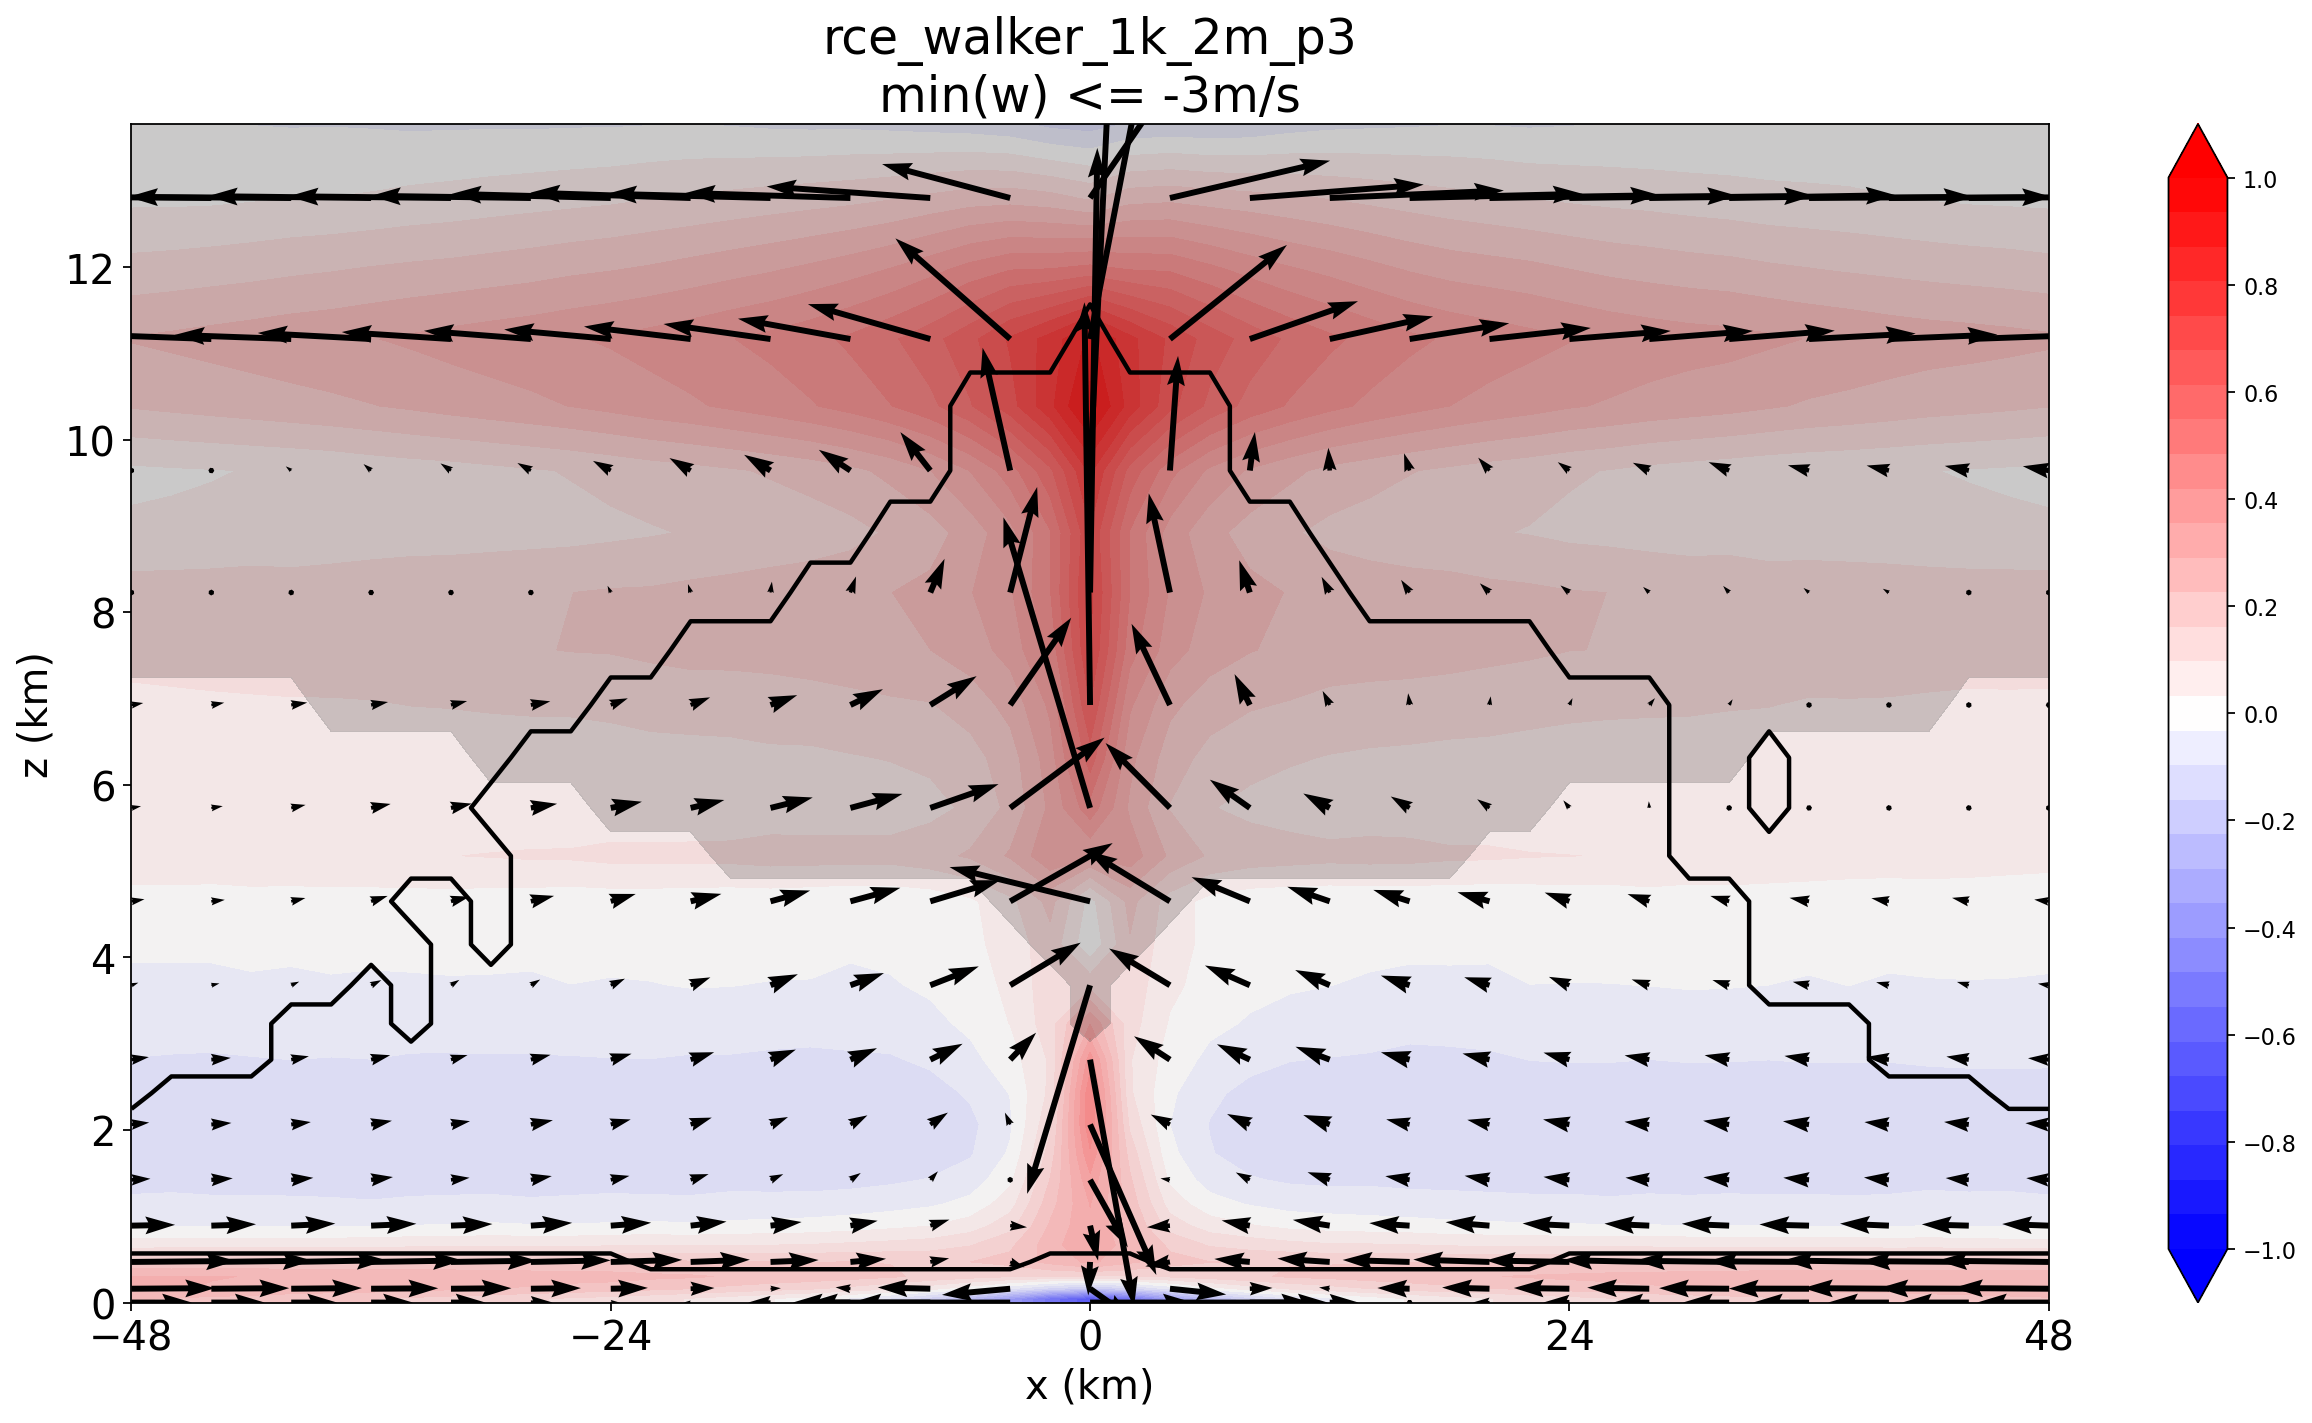

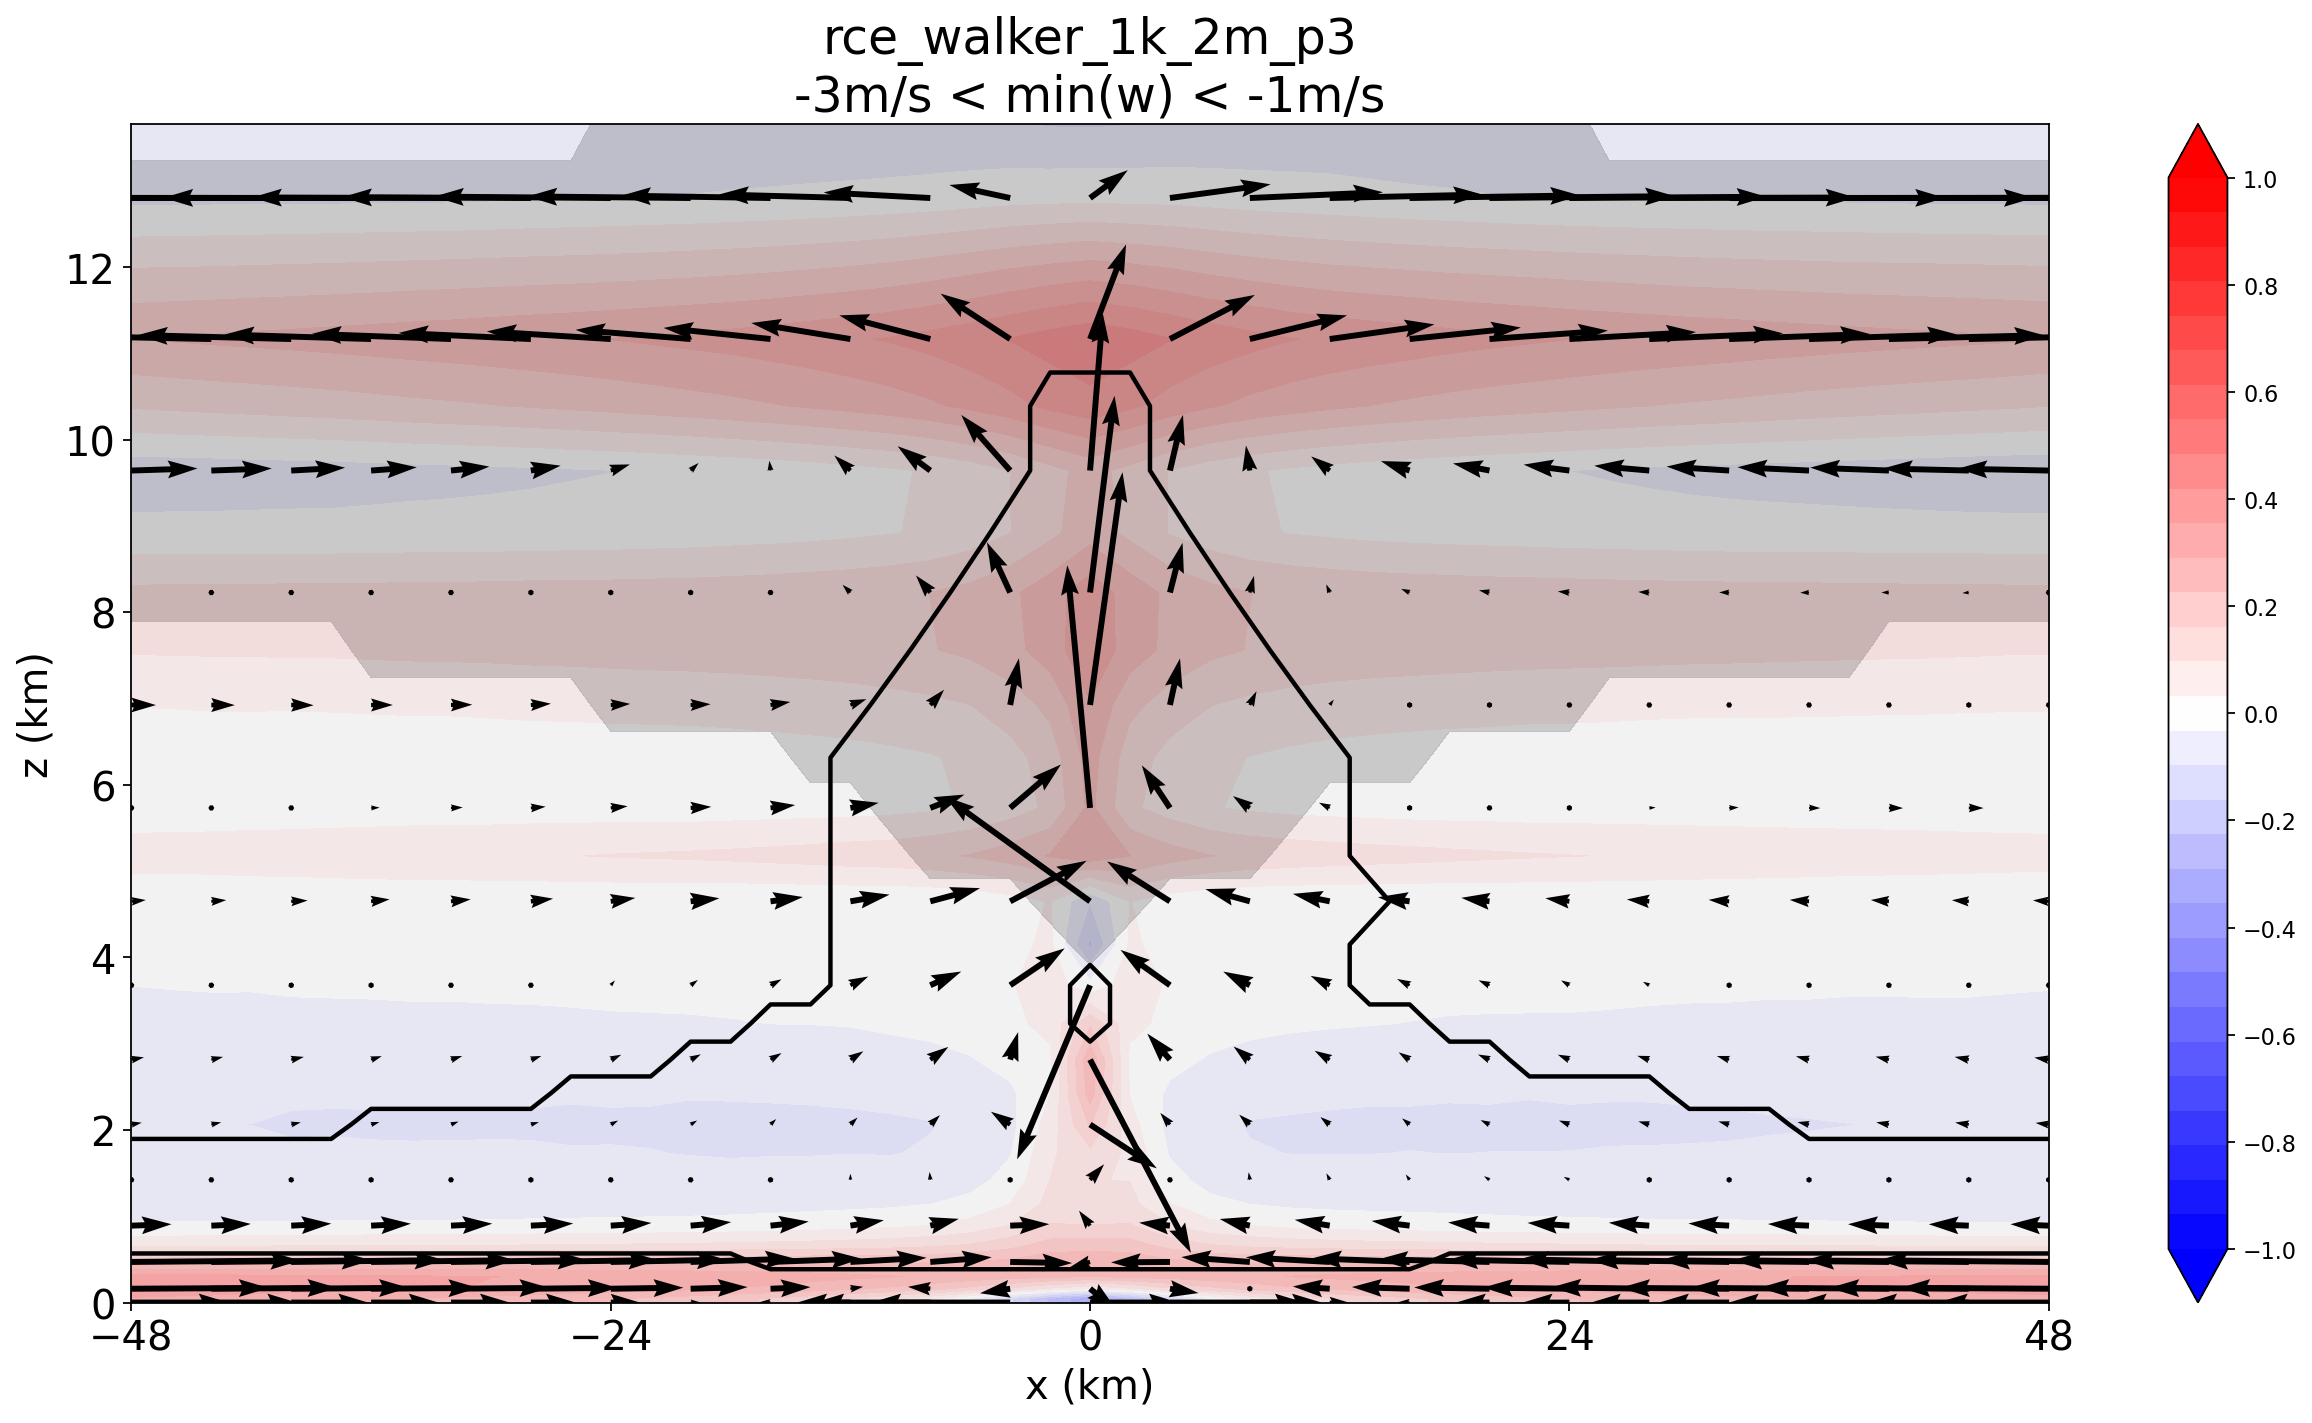

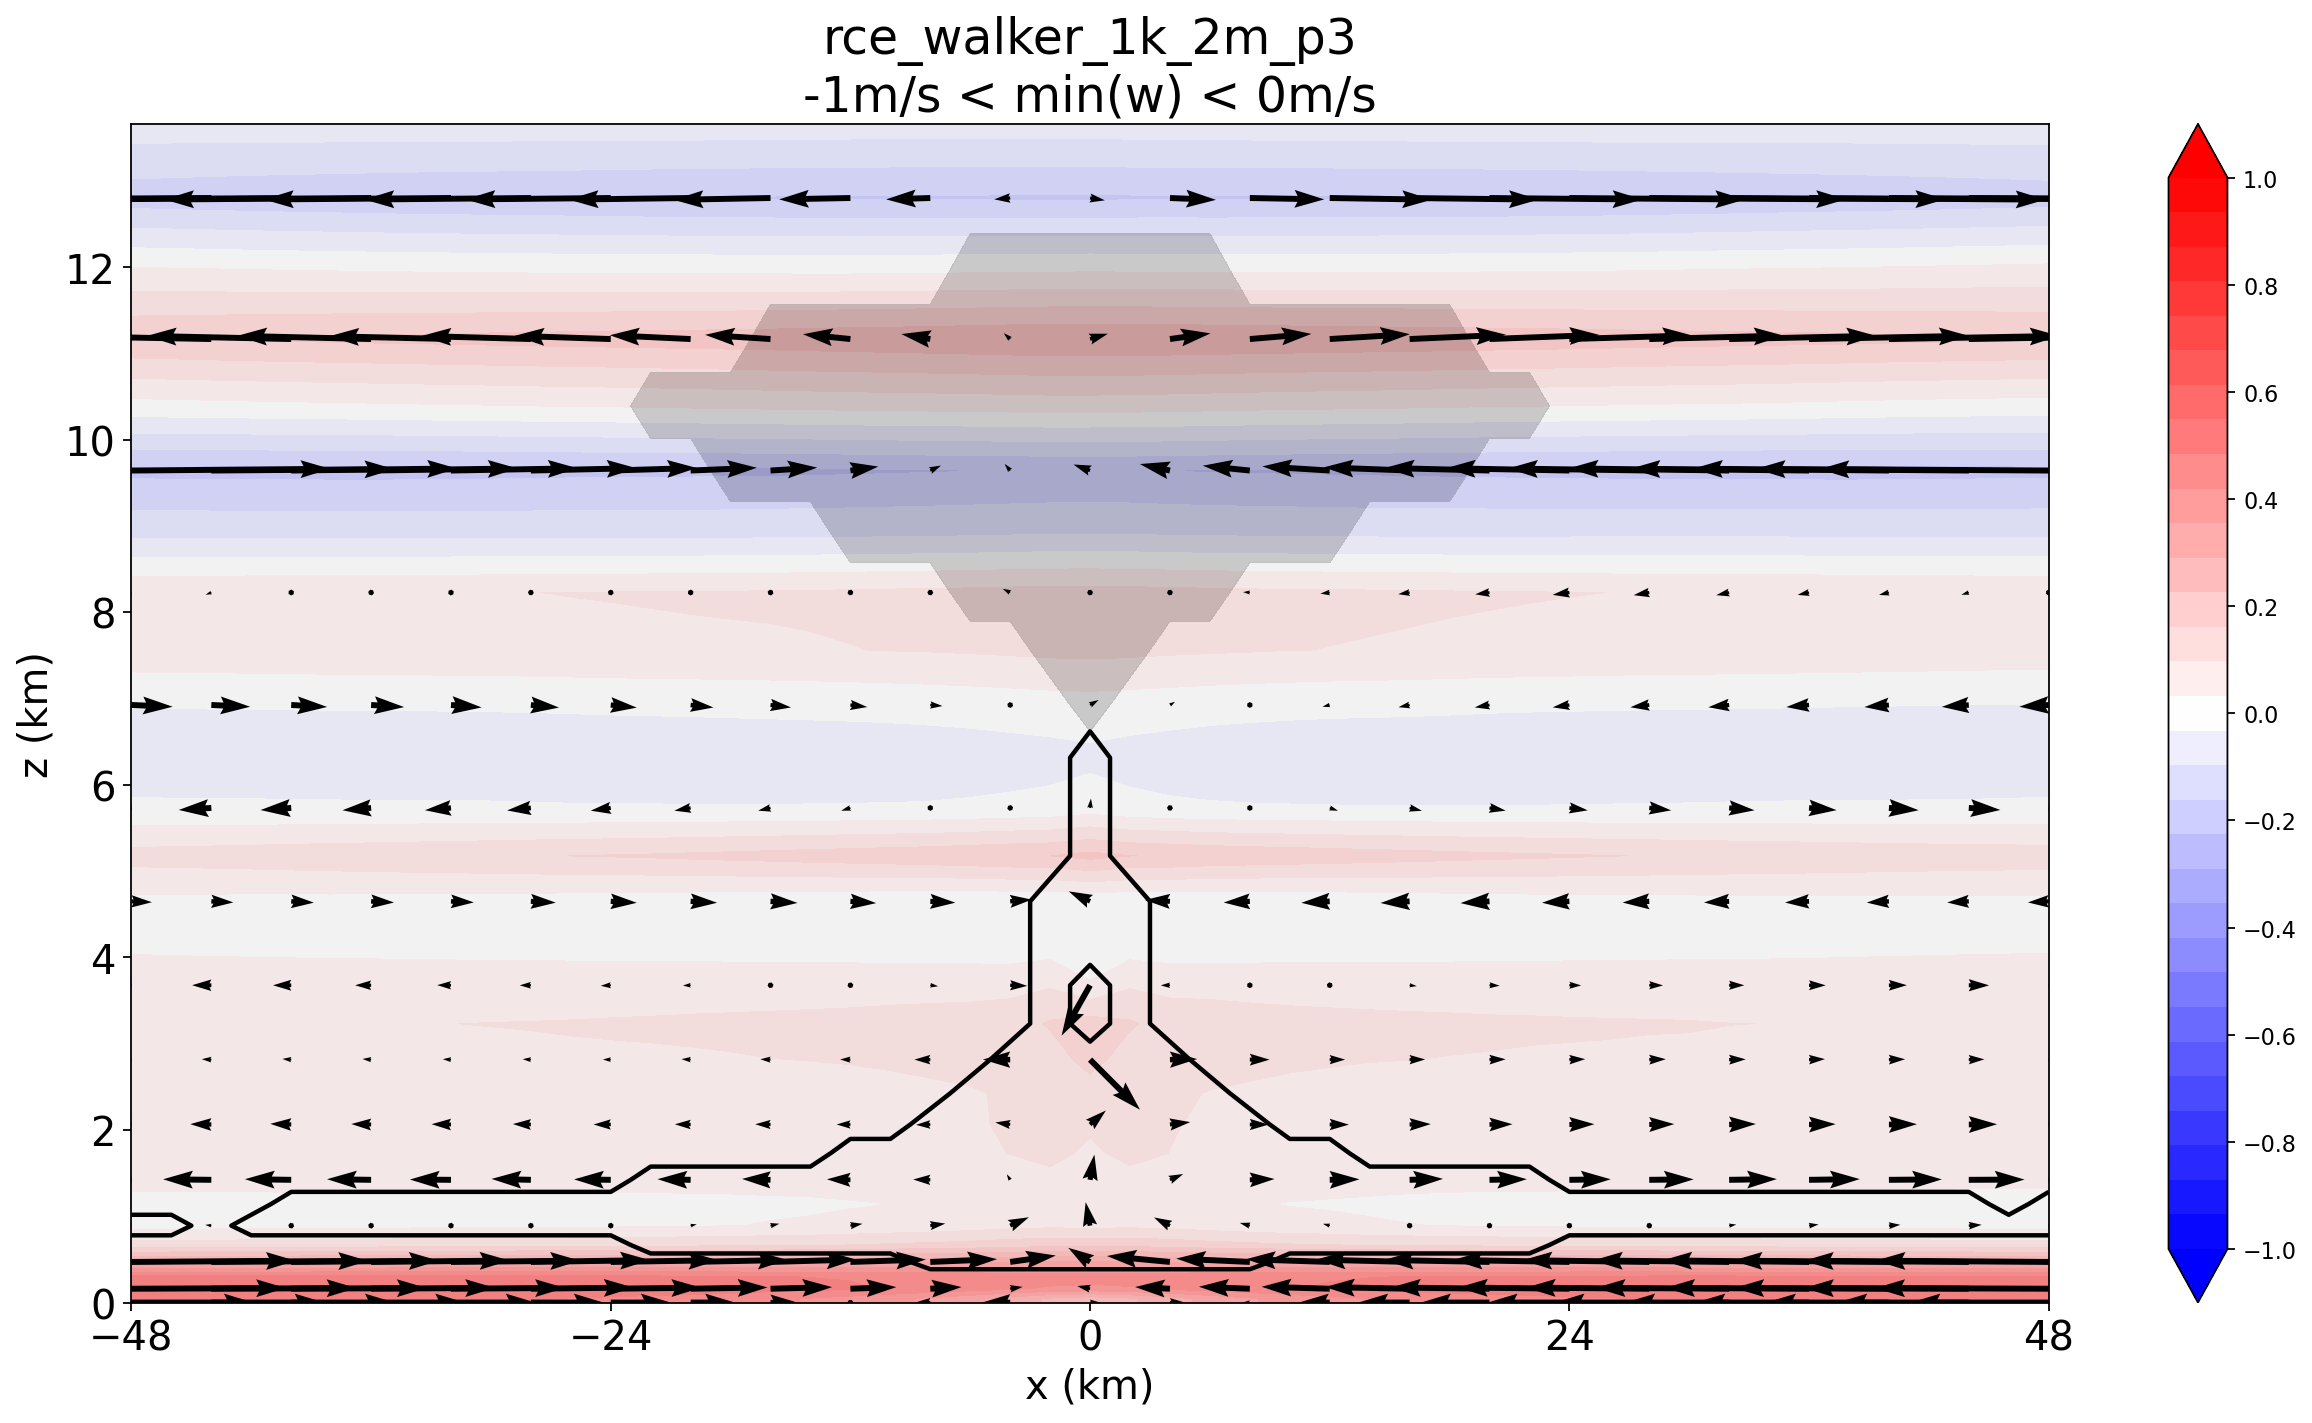

In [5]:
plt.figure(num = 1, 
           figsize = (16,9),
           dpi = 160)
plt.quiver(xx[::2,::2], zz[::2,::2], max_3_inf[0][::2,::2], max_3_inf[1][::2,::2], zorder = 10)
im = plt.contourf(xx, zz, max_3_inf[2], levels = np.linspace(-1,1,32), cmap = "bwr", extend = "both")
cbar = plt.colorbar(im)
cbar.set_ticks(np.linspace(-1,1,11))
plt.contourf(xx, zz, max_3_inf[4]>1e-4, cmap = "Greys", levels = 1, extend = 'max', alpha = 0.3)
plt.contour(xx, zz, max_3_inf[3]>1e-5, colors = "k", levels = [0.5], linewidths = 2)
plt.xlabel("x (km)", fontsize = 18)
plt.xticks(np.linspace(-48,48,5), fontsize = 18)
plt.ylabel("z (km)", fontsize = 18)
plt.yticks(np.linspace(0,12,7), fontsize = 18)
plt.title(f"{casenames[case_id][1:]}\nmax(w) >= 3m/s", fontsize = 22)
plt.tight_layout()
plt.savefig(f"{casenames[case_id][1:]}_pinf.png")

plt.figure(num = 2, 
           figsize = (16,9),
           dpi = 160)
plt.quiver(xx[::2,::2], zz[::2,::2], max_1_3[0][::2,::2], max_1_3[1][::2,::2], zorder = 10)
im = plt.contourf(xx, zz, max_1_3[2], levels = np.linspace(-1,1,32), cmap = "bwr", extend = "both")
cbar = plt.colorbar(im)
cbar.set_ticks(np.linspace(-1,1,11))
plt.contourf(xx, zz, max_1_3[4]>1e-4, cmap = "Greys", levels = 1, extend = 'max', alpha = 0.3)
plt.contour(xx, zz, max_1_3[3]>1e-5, colors = "k", levels = [0.5], linewidths = 2)
plt.xlabel("x (km)", fontsize = 18)
plt.xticks(np.linspace(-48,48,5), fontsize = 18)
plt.ylabel("z (km)", fontsize = 18)
plt.yticks(np.linspace(0,12,7), fontsize = 18)
plt.title(f"{casenames[case_id][1:]}\n1m/s < max(w) < 3m/s", fontsize = 22)
plt.tight_layout()
plt.savefig(f"{casenames[case_id][1:]}_p3.png")

plt.figure(num = 3, 
           figsize = (16,9),
           dpi = 160)
plt.quiver(xx[::2,::2], zz[::2,::2], max_0_1[0][::2,::2], max_0_1[1][::2,::2], zorder = 10)
im = plt.contourf(xx, zz, max_0_1[2], levels = np.linspace(-1,1,32), cmap = "bwr", extend = "both")
cbar = plt.colorbar(im)
cbar.set_ticks(np.linspace(-1,1,11))
plt.contourf(xx, zz, max_0_1[4]>1e-4, cmap = "Greys", levels = 1, extend = 'max', alpha = 0.3)
plt.contour(xx, zz, max_0_1[3]>1e-5, colors = "k", levels = [0.5], linewidths = 2)
plt.xlabel("x (km)", fontsize = 18)
plt.xticks(np.linspace(-48,48,5), fontsize = 18)
plt.ylabel("z (km)", fontsize = 18)
plt.yticks(np.linspace(0,12,7), fontsize = 18)
plt.title(f"{casenames[case_id][1:]}\n0m/s < max(w) < 1m/s", fontsize = 22)
plt.tight_layout()
plt.savefig(f"{casenames[case_id][1:]}_p1.png")

plt.figure(num = 4, 
           figsize = (16,9),
           dpi = 160)
plt.quiver(xx[::2,::2], zz[::2,::2], min_inf_3[0][::2,::2], min_inf_3[1][::2,::2], zorder = 10)
im = plt.contourf(xx, zz, min_inf_3[2], levels = np.linspace(-1,1,32), cmap = "bwr", extend = "both")
cbar = plt.colorbar(im)
cbar.set_ticks(np.linspace(-1,1,11))
plt.contourf(xx, zz, min_inf_3[4]>1e-4, cmap = "Greys", levels = 1, extend = 'max', alpha = 0.3)
plt.contour(xx, zz, min_inf_3[3]>1e-5, colors = "k", levels = [0.5], linewidths = 2)
plt.xlabel("x (km)", fontsize = 18)
plt.xticks(np.linspace(-48,48,5), fontsize = 18)
plt.ylabel("z (km)", fontsize = 18)
plt.yticks(np.linspace(0,12,7), fontsize = 18)
plt.title(f"{casenames[case_id][1:]}\nmin(w) <= -3m/s", fontsize = 22)
plt.tight_layout()
plt.savefig(f"{casenames[case_id][1:]}_ninf.png")

plt.figure(num = 5, 
           figsize = (16,9),
           dpi = 160)
plt.quiver(xx[::2,::2], zz[::2,::2], min_3_1[0][::2,::2], min_3_1[1][::2,::2], zorder = 10)
im = plt.contourf(xx, zz, min_3_1[2], levels = np.linspace(-1,1,32), cmap = "bwr", extend = "both")
cbar = plt.colorbar(im)
cbar.set_ticks(np.linspace(-1,1,11))
plt.contourf(xx, zz, min_3_1[4]>1e-4, cmap = "Greys", levels = 1, extend = 'max', alpha = 0.3)
plt.contour(xx, zz, min_3_1[3]>1e-5, colors = "k", levels = [0.5], linewidths = 2)
plt.xlabel("x (km)", fontsize = 18)
plt.xticks(np.linspace(-48,48,5), fontsize = 18)
plt.ylabel("z (km)", fontsize = 18)
plt.yticks(np.linspace(0,12,7), fontsize = 18)
plt.title(f"{casenames[case_id][1:]}\n-3m/s < min(w) < -1m/s", fontsize = 22)
plt.tight_layout()
plt.savefig(f"{casenames[case_id][1:]}_n3.png")

plt.figure(num = 6, 
           figsize = (16,9),
           dpi = 160)
plt.quiver(xx[::2,::2], zz[::2,::2], min_1_0[0][::2,::2], min_1_0[1][::2,::2], zorder = 10)
im = plt.contourf(xx, zz, min_1_0[2], levels = np.linspace(-1,1,32), cmap = "bwr", extend = "both")
cbar = plt.colorbar(im)
cbar.set_ticks(np.linspace(-1,1,11))
plt.contourf(xx, zz, min_1_0[4]>1e-4, cmap = "Greys", levels = 1, extend = 'max', alpha = 0.3)
plt.contour(xx, zz, min_1_0[3]>1e-5, colors = "k", levels = [0.5], linewidths = 2)
plt.xlabel("x (km)", fontsize = 18)
plt.xticks(np.linspace(-48,48,5), fontsize = 18)
plt.ylabel("z (km)", fontsize = 18)
plt.yticks(np.linspace(0,12,7), fontsize = 18)
plt.title(f"{casenames[case_id][1:]}\n-1m/s < min(w) < 0m/s", fontsize = 22)
plt.tight_layout()
plt.savefig(f"{casenames[case_id][1:]}_n1.png")